# Решение проектного задания весеннего интенсива по ML от Академии Яндекса
### **Команда "Саратовские вареники"**


## Импорт необходимых библиотек и датасета

In [ ]:
!pip install torchshow
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import torchshow as ts
import numpy as np
import matplotlib.pyplot as plt
import cv2
from livelossplot import PlotLossesKeras
from sklearn.utils import resample
import csv

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils import to_categorical
print(tf.__version__)

2.12.0


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml-intensive-of-yandex-academy-2023
!unzip ml-intensive-of-yandex-academy-2023.zip

100% 262M/263M [00:09<00:00, 24.5MB/s]
100% 263M/263M [00:09<00:00, 27.8MB/s]
Archive:  ml-intensive-of-yandex-academy-2023.zip
  inflating: data_test               
  inflating: data_train              
  inflating: meta                    


## Считывание данных

In [ ]:
train_and_val = pd.read_pickle('data_train')
test= pd.read_pickle('data_test')

train_and_val_images = train_and_val['images']
train_and_val_labels = train_and_val['labels']
# train_and_val_labels = np.eye(10)[train_and_val_labels]

test_images = test["images"]
print(f'Train data keys: {train_and_val.keys()}')
print(f'Test data keys: {test.keys()}\n')
print(f'Shape of train images: {train_and_val_images.shape}')
print(f'Shape of test images: {test["images"].shape}\n')
print(f'Unique labels: {set(train_and_val_labels )}\n')
print(f'Classes distribution: {pd.Series(train_and_val_labels).value_counts(normalize=True)}')

Train data keys: dict_keys(['section', 'labels', 'images'])
Test data keys: dict_keys(['section', 'images'])

Shape of train images: (50000, 32, 32, 3)
Shape of test images: (25000, 32, 32, 3)

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Classes distribution: 1    0.19300
2    0.15190
3    0.11250
4    0.09882
5    0.09208
7    0.07752
6    0.07718
0    0.06682
8    0.06664
9    0.06354
dtype: float64


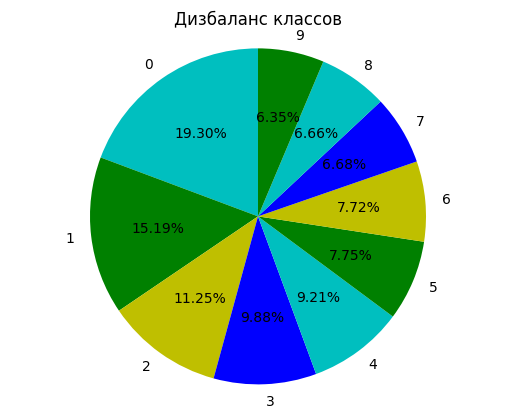

In [ ]:
labels = set(train_and_val_labels)
sections = pd.Series(train_and_val_labels).value_counts(normalize=True)
colors = ['c', 'g', 'y', 'b']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Дизбаланс классов')
plt.show()

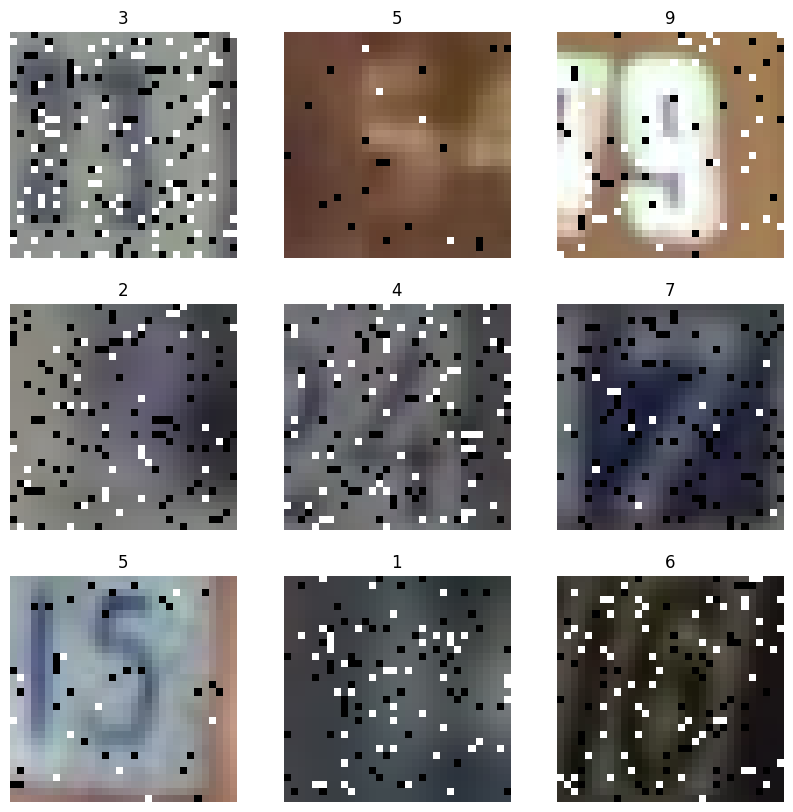

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(len(train_and_val_images))
    image = np.array(train_and_val_images)[idx]
    label = np.array(train_and_val_labels)[idx]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(label)
    plt.axis("off")

Нетрудно заметить две главные проблемы датасета - дисбаланс классов и состояние картинок (шум из белых и чёрных пикселей).

## Предподготовка датасета <br>

### Downsampling<br>
В датасете наблюдался дизбаланс классов: для примера, единиц было в три раза больше, чем девяток.
Возьмем от каждого класса какую-то часть так, чтобы объектов в классах было поровну

In [ ]:
data = {'id': list(range(50000)), 'labels': train_and_val_labels }
df = pd.DataFrame.from_dict(data)
# Downsampling
k = int(50000 * 0.09)
out = pd.DataFrame()
for i in range(10):
    
    res = resample(df[df["labels"] == i],
             replace=True,
             n_samples=k,
             random_state=42)
    out = pd.concat([out, res])

print(f'Classes distribution:\n{out.labels.value_counts(normalize=True)}')


Classes distribution:
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: labels, dtype: float64


In [ ]:
pics = []
labs = []
for elem in out['id']:
  pics.append(train_and_val_images[elem])
labs = np.array(out['labels'])

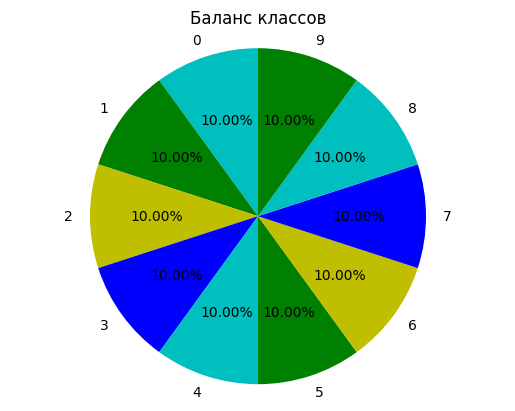

In [ ]:
labels = set(labs)
sections = out.labels.value_counts(normalize=True)
colors = ['c', 'g', 'y', 'b']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.axis('equal')
plt.title('Баланс классов')
plt.show()

### Фильтры для чистки изображений от шума

Изначально была придумана функция усреднения для белых и чёрных пикселей - вычислялось среднее значение цвета 8 соседних пикселей и ставилось на место заменяемого пикселя. Также была реализована черно-белая версия функции.

In [ ]:
def antinoise(image):
    for x in range(32):
        for y in range(32):
            if not(image[x][y].any()) or not((image[x][y] - np.array([255., 255., 255.])).any()):
                k = 0
                a = np.array([0., 0., 0.])
                if x > 0 and y > 0:
                    a += image[x - 1][y - 1]
                    k += 1
                if x > 0 and y < 31:
                    a += image[x - 1][y + 1]
                    k += 1
                if x < 31 and y < 31:
                    a += image[x + 1][y + 1]
                    k += 1
                if x  < 31 and y > 0:
                    a += image[x + 1][y - 1]
                    k += 1
                if x > 0:
                    a += image[x - 1][y]
                    k += 1
                if y > 0:
                    a += image[x][y - 1]
                    k += 1
                if x < 31:
                    a += image[x + 1][y]
                    k += 1
                if y < 31:
                    a += image[x][y + 1]
                    k += 1
                a //= k
                image[x][y] = a
    return image

In [ ]:
def antinoise_grey(image):
    for x in range(32):
        for y in range(32):
            if not(image[x][y].any()) or not((image[x][y] - np.array([255., 255., 255.])).any()):
                k = 0
                a = np.array([0., 0., 0.])
                if x > 0 and y > 0:
                    a += image[x - 1][y - 1]
                    k += 1
                if x > 0 and y < 31:
                    a += image[x - 1][y + 1]
                    k += 1
                if x < 31 and y < 31:
                    a += image[x + 1][y + 1]
                    k += 1
                if x  < 31 and y > 0:
                    a += image[x + 1][y - 1]
                    k += 1
                if x > 0:
                    a += image[x - 1][y]
                    k += 1
                if y > 0:
                    a += image[x][y - 1]
                    k += 1
                if x < 31:
                    a += image[x + 1][y]
                    k += 1
                if y < 31:
                    a += image[x][y + 1]
                    k += 1
                a //= k
                image[x][y] = a
                
            grey = image[x][y][0] * 0.3 + image[x][y][1] * 0.59 + image[x][y][2] * 0.11
            image[x][y] = np.array([grey, grey, grey])
            
    return image

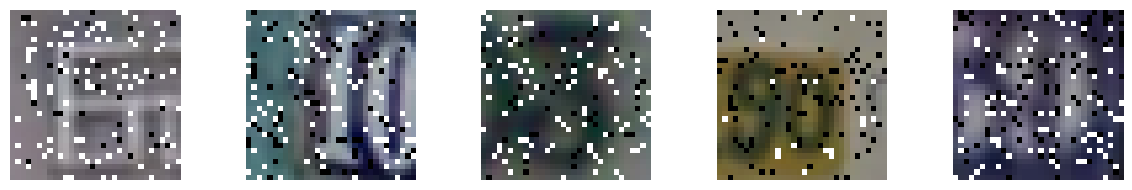

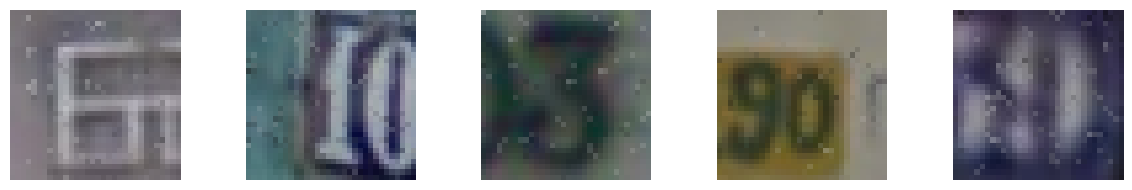

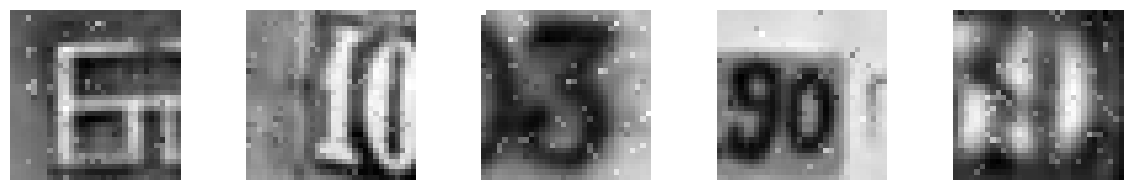

In [ ]:
images = []
for i in range(5):
    idx = np.random.randint(len(pics))
    image = np.array(pics)[idx]
    images.append(image)
ts.show(images, nrows=1, figsize=(12, 2))
for elem in images:
    antinoise(elem)
ts.show(images, nrows=1, figsize=(12, 2))
for elem in images:
    antinoise_grey(elem)
ts.show(images, nrows=1, figsize=(12, 2))

У данного метода есть несколько минусов. Во-первых преобразование всего датасета этими функциями занимает около 10 минут, а во-вторых при большом количестве шума обработка получается не очень качественной.

Далее был реализован медианный фильтр (функция + уже готовый в OpenCV)

In [ ]:
def mid_grey(image):
    for x in range(1, 31):
        for y in range(1, 31):
            k = []
            k.append(image[x][y][0] * 0.3 + image[x][y][1] * 0.59 + image[x][y][2] * 0.11)
            k.append(image[x - 1][y][0] * 0.3 + image[x - 1][y][1] * 0.59 + image[x - 1][y][2] * 0.11)
            k.append(image[x - 1][y - 1][0] * 0.3 + image[x - 1][y - 1][1] * 0.59 + image[x - 1][y - 1][2] * 0.11)
            k.append(image[x][y - 1][0] * 0.3 + image[x][y - 1][1] * 0.59 + image[x][y - 1][2] * 0.11)
            k.append(image[x + 1][y][0] * 0.3 + image[x + 1][y][1] * 0.59 + image[x + 1][y][2] * 0.11)
            k.append(image[x + 1][y + 1][0] * 0.3 + image[x + 1][y + 1][1] * 0.59 + image[x + 1][y + 1][2] * 0.11)
            k.append(image[x][y + 1][0] * 0.3 + image[x][y + 1][1] * 0.59 + image[x][y + 1][2] * 0.11)
            k.append(image[x - 1][y + 1][0] * 0.3 + image[x - 1][y + 1][1] * 0.59 + image[x - 1][y + 1][2] * 0.11)
            k.append(image[x + 1][y - 1][0] * 0.3 + image[x + 1][y - 1][1] * 0.59 + image[x + 1][y - 1][2] * 0.11)
            k.sort()
            image[x][y] = np.array([k[4], k[4], k[4]])
    for x in range(32):
        image[x][0] = np.array([255., 255., 255.])
        image[x][-1] = np.array([255., 255., 255.])
        image[0][x] = np.array([255., 255., 255.])
        image[-1][x] = np.array([255., 255., 255.])
            
    return image

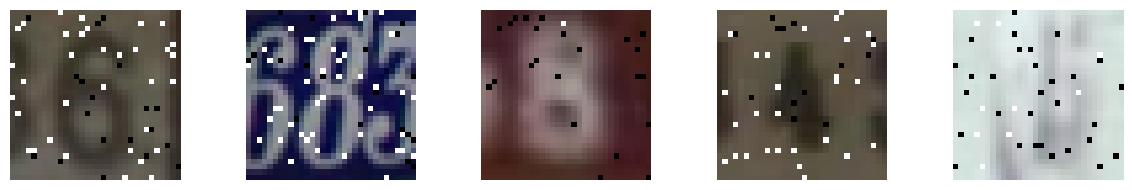

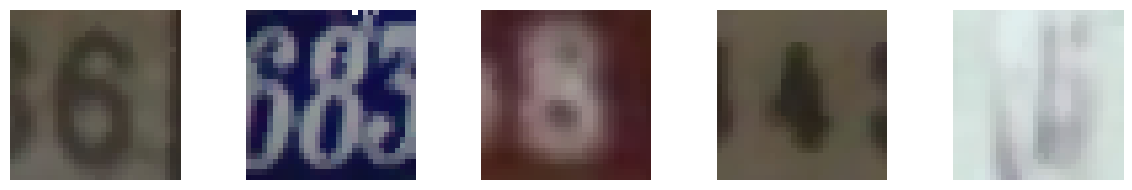

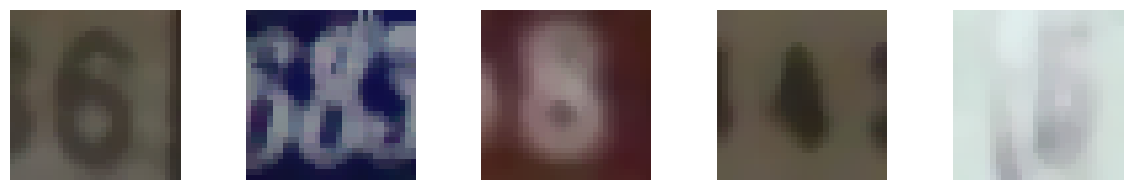

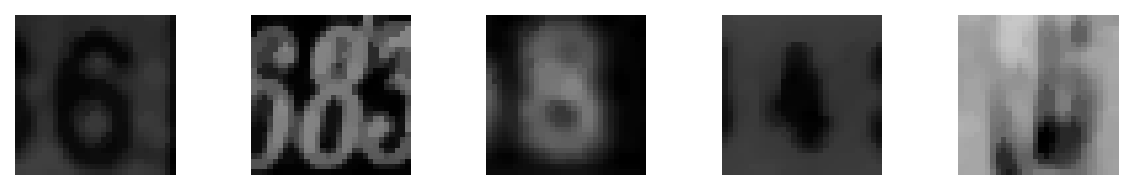

In [ ]:
images = []
for i in range(5):
    idx = np.random.randint(len(pics))
    image = np.array(pics)[idx]
    images.append(image)
ts.show(images, nrows=1, figsize=(12, 2))
processed_image = []
for elem in images:
    processed_image.append(cv2.medianBlur(elem, 3))
ts.show(processed_image, nrows=1, figsize=(12, 2))
processed_image = []
for elem in images:
    processed_image.append(cv2.medianBlur(elem, 5))
ts.show(processed_image, nrows=1, figsize=(12, 2))
for elem in images:
    mid_grey(elem)
ts.show(images, nrows=1, figsize=(12, 2))

Медианный фильтр справляется с шумом лучше. Однако вручную написанная функция обрабатывает датасет за 20 минут, поэтому был применён медианный фильтр из OpenCV.

In [ ]:
from tqdm.notebook import tqdm
for i in tqdm(range(len(pics))):
    pics[i] =  cv2.medianBlur(pics[i], 3)
for i in tqdm(range(len(test['images']))):
    test['images'][i] =  cv2.medianBlur(test['images'][i], 3)

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Проверка того, что обработка датасета прошла успешно.

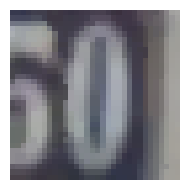

In [ ]:
ts.show(pics[1456], nrows=1, figsize=(12, 2))

## Разделение на обучающую и валидационную выборки


###Если данные не обработаны

In [ ]:
val_size = 0.01

train_images, validation_images, train_labels, validation_labels = train_test_split(pics, labs, test_size=val_size, random_state=2,) 

In [ ]:

data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2),
])
batch_size = 512
val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
val_dataset = val_dataset.batch(batch_size)

trainDS = tf.data.Dataset.from_tensor_slices((train_images, train_labels))


In [ ]:
# Выгрузка датасетов
tf.data.Dataset.save(trainDS, "train_dataset")
tf.data.Dataset.save(val_dataset, "val_dataset")


###Если данные обработаны

In [ ]:
# Загрузка датасетов
trainDS = tf.data.Dataset.load("train_dataset")
val_dataset = tf.data.Dataset.load("val_dataset")


###/

In [ ]:
batch_size = 512
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2),
])

trainDS = (
    trainDS
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

## Res-net


Изначальная модель, выбранная как база для доработки.

In [ ]:
_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
input_shape = train_and_val_images.shape[-3:]

inputs = tf.keras.layers.Input(shape=input_shape)
rescal = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')(rescal)
conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1)
pooling1 = tf.keras.layers.MaxPooling2D((3, 3))(conv2)

conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(pooling1)
conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv3)

added1 = tf.keras.layers.Add()([conv4, pooling1])

conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(added1)
conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv5)

added2 = tf.keras.layers.Add()([conv6, added1])

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu')(added2)
pooling2 = tf.keras.layers.GlobalAveragePooling2D()(conv7)
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooling2)
drop_out = tf.keras.layers.Dropout(0.5)(dense1)
feature = tf.keras.layers.Dense(10, activation="softmax")(drop_out)

res_net_cnn = tf.keras.Model(inputs, feature)

res_net_cnn.compile(
    optimizer="adamax",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
res_net_cnn.fit(
    x=pics,
    y=labs,
    batch_size=128,
    epochs=50,
    callbacks=[_callback, PlotLossesKeras()],
    validation_split=0.2,
    shuffle=True
)

с добавлением SharpnessAwareMinimization.

In [ ]:
_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
input_shape = train_and_val_images.shape[-3:]

inputs = tf.keras.layers.Input(shape=input_shape)
rescal = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')(rescal)
conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1)
pooling1 = tf.keras.layers.MaxPooling2D((3, 3))(conv2)

conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(pooling1)
conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv3)

added1 = tf.keras.layers.Add()([conv4, pooling1])

conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(added1)
conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv5)

added2 = tf.keras.layers.Add()([conv6, added1])

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu')(added2)
pooling2 = tf.keras.layers.GlobalAveragePooling2D()(conv7)
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooling2)
drop_out = tf.keras.layers.Dropout(0.5)(dense1)
feature = tf.keras.layers.Dense(10)(drop_out)

res_net_cnn3 = tf.keras.models.experimental.SharpnessAwareMinimization(
    tf.keras.Model(inputs, feature),
    rho=0.1
)

res_net_cnn3.compile(
    optimizer="adamax",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
res_net_cnn3.fit(
    x=pics,
    y=labs,
    batch_size=128,
    epochs=50,
    callbacks=[_callback, PlotLossesKeras()],
    validation_split=0.1,
    shuffle=True
)

In [ ]:
preds = res_net_cnn3.predict(test['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('res_net_old.csv', index=False)

с другим оптимизатором и trainDS (самая лучшая модель).

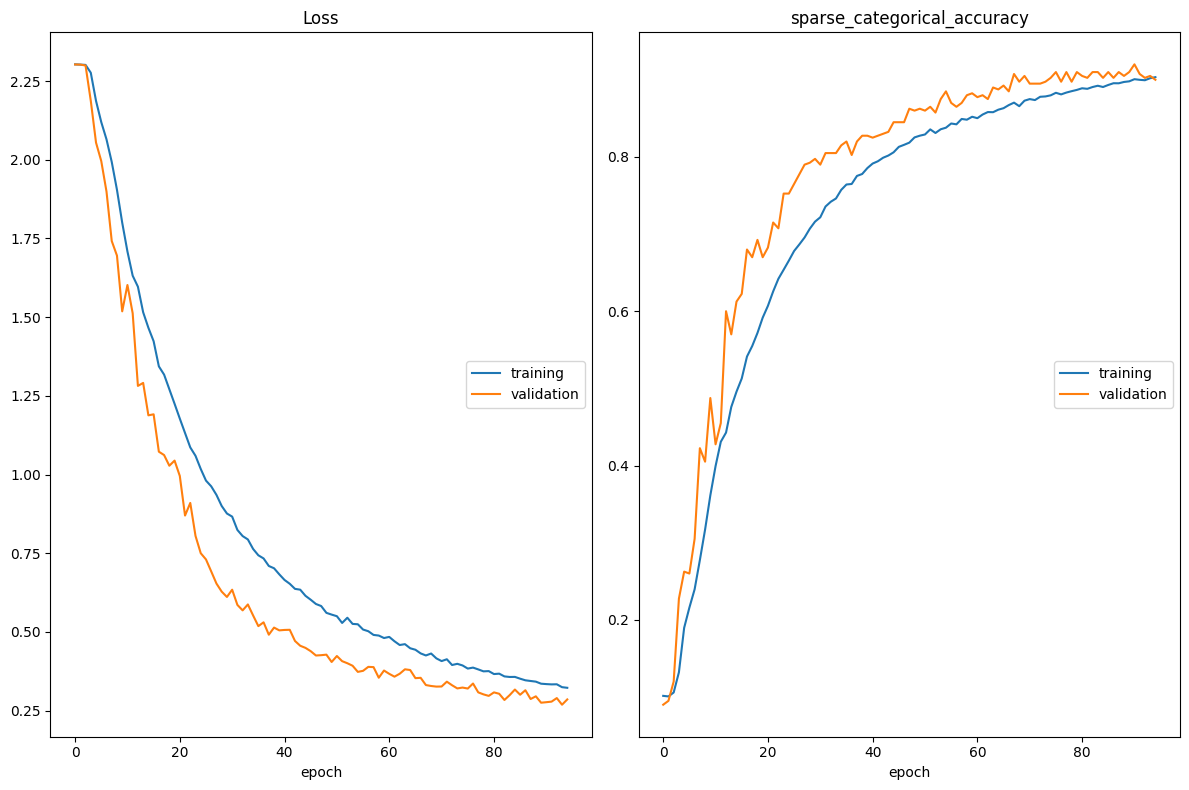

Loss
	training         	 (min:    0.322, max:    2.303, cur:    0.322)
	validation       	 (min:    0.268, max:    2.303, cur:    0.285)
sparse_categorical_accuracy
	training         	 (min:    0.101, max:    0.903, cur:    0.903)
	validation       	 (min:    0.090, max:    0.920, cur:    0.900)
78/78 [==============================] - 54s 673ms/step - loss: 0.3222 - sparse_categorical_accuracy: 0.9034 - val_loss: 0.2852 - val_sparse_categorical_accuracy: 0.9000
Epoch 96/100
65/78 [========================>.....] - ETA: 9s - loss: 0.3209 - sparse_categorical_accuracy: 0.9036 

In [ ]:
_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
input_shape =  train_and_val_images.shape[-3:]

inputs = tf.keras.layers.Input(shape=input_shape)
rescal = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')(rescal)
conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1)
pooling1 = tf.keras.layers.MaxPooling2D((3, 3))(conv2)

conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(pooling1)
conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv3)

added1 = tf.keras.layers.Add()([conv4, pooling1])

conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(added1)
conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same")(conv5)

added2 = tf.keras.layers.Add()([conv6, added1])

conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu')(added2)
pooling2 = tf.keras.layers.GlobalAveragePooling2D()(conv7)
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooling2)
drop_out = tf.keras.layers.Dropout(0.5)(dense1)
feature = tf.keras.layers.Dense(10, activation="softmax")(drop_out)

res_net_cnn2 = tf.keras.Model(inputs, feature)

res_net_cnn2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

res_net_cnn2.fit(
    trainDS,
    batch_size=128,
    epochs=150,
    callbacks=[PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

In [ ]:
preds = res_net_cnn2.predict(test['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub_res_net_cnn_mega.csv', index=False)

## U-net


In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [ ]:
class U_net:
    def convolution_operation(self, entered_input, filters=64):
        # Taking first input and implementing the first conv block
        conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
        batch_norm1 = BatchNormalization()(conv1)
        act1 = ReLU()(batch_norm1)
        
        # Taking first input and implementing the second conv block
        conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
        batch_norm2 = BatchNormalization()(conv2)
        act2 = ReLU()(batch_norm2)
        
        return act2
    def encoder(self, entered_input, filters=64):
        # Collect the start and end of each sub-block for normal pass and skip connections
        enc1 = self.convolution_operation(entered_input, filters)
        MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
        return enc1, MaxPool1
    def decoder(self, entered_input, skip, filters=64):
        # Upsampling and concatenating the essential features
        Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
        Connect_Skip = Concatenate()([Upsample, skip])
        out = self.convolution_operation(Connect_Skip, filters)
        return out

    def build(self, Image_Size):
        # Take the image size and shape
        input1 = Input(Image_Size)
        
        # Construct the encoder blocks
        skip1, encoder_1 = self.encoder(input1, 16)
        skip2, encoder_2 = self.encoder(encoder_1, 16*2)
        skip3, encoder_3 = self.encoder(encoder_2, 16*4)
        skip4, encoder_4 = self.encoder(encoder_3, 16*8)
        
        # Preparing the next block
        conv_block = self.convolution_operation(encoder_4, 16*16)
       
        # Construct the decoder blocks
        decoder_1 = self.decoder(conv_block, skip4, 16*8)
        decoder_2 = self.decoder(decoder_1, skip3, 16*4)
        decoder_3 = self.decoder(decoder_2, skip2, 16*2)
        decoder_4 = self.decoder(decoder_3, skip1, 16)
        
        # out = Conv2D(1, 1, padding="same", activation="softmax")(decoder_4)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(decoder_4)
        outputs = tf.keras.layers.Flatten()(outputs)
        model = Model(input1, outputs)
        return model
input_shape = (32, 32, 3)
u_net = U_net().build(input_shape)


# tf.keras.utils.plot_model(u_net, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

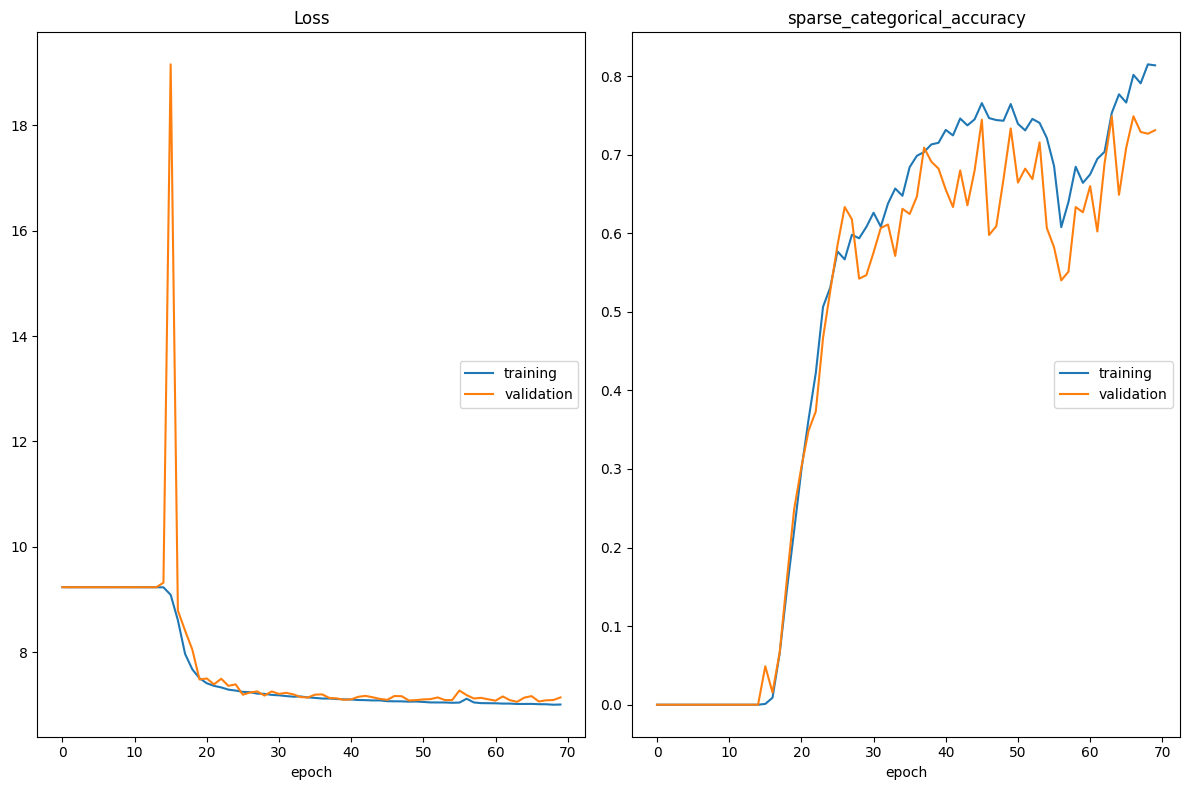

Loss
	training         	 (min:    7.006, max:    9.236, cur:    7.009)
	validation       	 (min:    7.061, max:   19.154, cur:    7.144)
sparse_categorical_accuracy
	training         	 (min:    0.000, max:    0.815, cur:    0.814)
	validation       	 (min:    0.000, max:    0.749, cur:    0.731)
88/88 [==============================] - 10s 113ms/step - loss: 7.0090 - sparse_categorical_accuracy: 0.8136 - val_loss: 7.1437 - val_sparse_categorical_accuracy: 0.7311


In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

optimizer = Adam()
u_net.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy']
)

u_net.fit(
    trainDS,
    batch_size=128,
    epochs=70,
    callbacks=[PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

In [ ]:
preds = u_net.predict(test['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub_u_net.csv', index=False)

782/782 [==============================] - 6s 6ms/step


## VGG

Вместо реализации модели с нуля был опробован метод подгонки уже обученной модели под необходимый паттерн ответов, однако, результат получился довольно низкий.

In [ ]:
from keras.applications import VGG16

In [ ]:
input_layer=layers.Input(shape=(32, 32, 3))
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
last_layer = model_vgg16.output
flatten = layers.Flatten()(last_layer)
dense1 = layers.Dense(100, activation='relu')(flatten)
dense1 = layers.Dense(100, activation='relu')(flatten)
dense1 = layers.Dense(100, activation='relu')(flatten)
output_layer = layers.Dense(1, activation='softmax')(flatten)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
for layer in model.layers[:-1]:
    layer.trainable=False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
model.fit(
    x=pics,
    y=labs,
    batch_size=128,
    epochs=70,
    callbacks=[_callback, PlotLossesKeras()],
    validation_data=val_dataset,
    shuffle=True
)

NameError: ignored

In [ ]:
preds = model.predict(test['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub_vgg.csv', index=False)

## Вывод

Усреднение ответов трёх лучших моделей.

Лучшим решением стал ансамбль из трех моделей:
* u_net Score: 0.911
* res_net на выборке без аугментаций Score: 0.92186
* res_net на выборке с аугментациями Score: 0.9088 <br><br>
Общий Score 0.9312




In [ ]:
f1 = open('sub_u_net.csv', 'r')
f2 = open('res_net_old.csv', 'r')
f3 = open('sub_res_net_cnn_mega.csv', 'r')
a1, a2, a3 = [], [], []
ans = []
for elem in f1:
    a1.append(int(elem.split(',')[1]))
for elem in f2:
    a2.append(int(elem.split(',')[1]))
for elem in f3:
    a3.append(int(elem.split(',')[1]))
with open('answer.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='*', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['Id', 'Category'])
    for i in range(len(a1)):
        filewriter.writerow([i, sorted([a1[i], a2[i], a3[i]])[1]])

График обученной модели<br>
U_net<br>
![](https://drive.google.com/uc?export=view&id=1otA-E53UQUMchTIXQ6bU3gwgCNodgwNH)

